# **Face Generation**

In this project, you'll define and train a DCGAN on a dataset of faces. Goal is to get a generator network to generate new images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from loading in data to defining and training adversarial networks. At the end of the notebook, visualize the results of trained Generator to see how it performs,generated samples should look like fairly realistic faces with small amounts of noise.

CelebA data can be downloaded from this link:-
[download](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)


# **Dowloading data in colab**

In [ ]:
# !wget -c 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip'
# !unzip '/content/processed-celeba-small.zip'

## ***Pre-process and Load the Data***

In [5]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
from torchvision import datasets
from torchvision import transforms

In [7]:
def get_dataloader(batch_size, image_size, data_dir='/content/processed_celeba_small'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor()])
    # TODO: Implement function and return a dataloader
    dataset = datasets.ImageFolder(data_dir,transform = transform)
    
    dataloader = torch.utils.data.DataLoader(dataset = dataset,batch_size = batch_size,shuffle = True)
    return dataloader

In [9]:
batch_size = 256
img_size = 32


# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

## ***Visualize the CelebA Data***

The CelebA dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with 3 color channels (RGB) each.

torch.Size([256, 3, 32, 32])


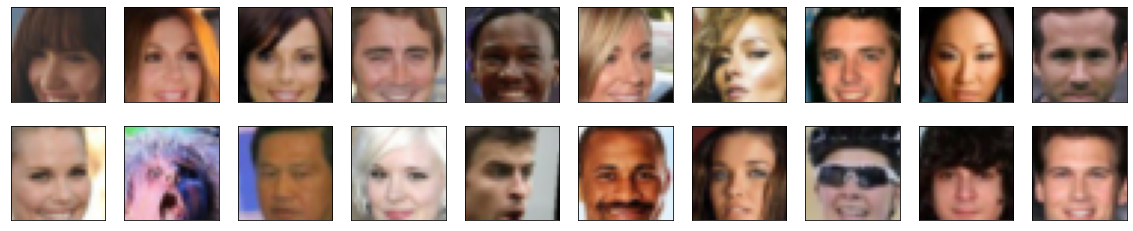

In [10]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

***Pre-process your image data and scale it to a pixel range of -1 to 1***

You need to do a bit of pre-processing; you know that the output of a tanh activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [ ]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max-min) + min
    return x

In [ ]:
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8980)


In [ ]:
images.shape

torch.Size([256, 3, 64, 64])

# ***Discriminator***

First task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested use a deep network with normalization. And allowed to create any helper functions that may be useful.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def conv(input_c,output,kernel_size,stride = 2,padding  = 1, batch_norm = True):
    layers =[]
    con = nn.Conv2d(input_c,output,kernel_size,stride,padding,bias = False)
    layers.append(con)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(output))
    
    return nn.Sequential(*layers)

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.layer_1 = conv(3,conv_dim,4,batch_norm = False) #16
        self.layer_2 = conv(conv_dim,conv_dim*2,4) #8
        self.layer_3 = conv(conv_dim*2,conv_dim*4,4) #4
        self.fc = nn.Linear(conv_dim*4*4*4,1)
        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.layer_1(x))
        x = F.leaky_relu(self.layer_2(x))
        x = F.leaky_relu(self.layer_3(x))
        x = x.view(-1,self.conv_dim*4*4*4)
        x = self.fc(x)
        return x


# ***Generator***

The generator should upsample an input and generate a new image of the same size as our training data 32x32x3. This should be mostly transpose convolutional layers with normalization applied to the outputs.

In [ ]:
def deconv(input_c,output,kernel_size,stride = 2, padding =1, batch_norm = True):
    layers = []
    decon = nn.ConvTranspose2d(input_c,output,kernel_size,stride,padding,bias = False)
    layers.append(decon)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(output))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size,conv_dim*8*2*2)
        self.layer_1 = deconv(conv_dim*8,conv_dim*4,4)
        self.layer_2 = deconv(conv_dim*4,conv_dim*2,4)
        self.layer_3 = deconv(conv_dim*2,conv_dim,4)
        self.layer_4 = deconv(conv_dim,3,4,batch_norm = False)
        # complete init function
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1,self.conv_dim*8,2,2) #(batch_size,depth,width,height)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = torch.tanh(self.layer_4(x))
        return x


**All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.**

In [ ]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m,'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        
        m.weight.data.normal_(0.0,0.02)
    
        if hasattr(m,'bias') and m.bias is not None:
            m.bias.data.zero_()

# ***Build complete network***

Defining models' hyperparameters and instantiate the discriminator and generator from the classes defined above.

In [ ]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [ ]:
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (layer_1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding

In [ ]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


# ***Discriminator and Generator Losses***

Now we need to calculate the losses for both types of adversarial networks.

**Discriminator Losses**



*   For the discriminator, the total loss is the sum of the losses for real and fake images, d_loss = d_real_loss + d_fake_loss.
*   Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.



**Generator Loss**

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to think its generated images are real.

In [ ]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion =  nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [ ]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr = .0002, betas = [0.5,0.999])
g_optimizer = optim.Adam(G.parameters(),lr = .0002, betas = [0.5,0.999])

# ***Training***

In [ ]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()
            # ===============================================
            #         CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            d_out_real = D(real_images)
            z = np.random.uniform(-1,1,size = (batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            d_loss = real_loss(d_out_real) + fake_loss(D(G(z)))
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            G.train()
            g_optimizer.zero_grad()
            z = np.random.uniform(-1,1,size = (batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            g_loss = real_loss(D(G(z)))
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses


In [ ]:
n_epochs = 30

# call training function
losses = train(D, G, n_epochs=n_epochs)

# ***Training Loss***

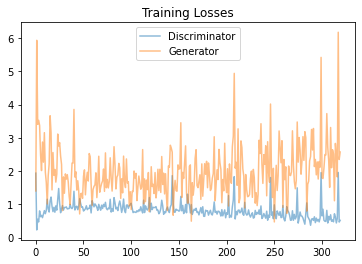

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# ***Generator samples from training***

In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255/2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    

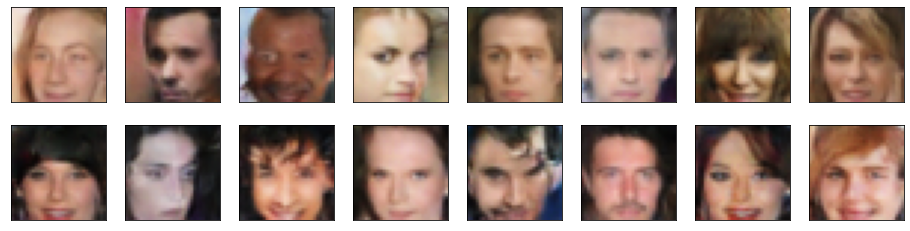

In [ ]:
_ = view_samples(-1, samples)

# ***Saving Model and Optimimzers States***

In [ ]:
# import torch
# torch.save({
#             'model_D_state_dict': D.state_dict(),
#             'model_G_state_dict': G.state_dict(),
#             'optimizer_D_state_dict': d_optimizer.state_dict(),
#             'optimizer_G_state_dict': g_optimizer.state_dict()
#             }, '/content/drive/My Drive/GAN/DCGAN_DEEPFAKE/deepfake_models_state.tar')